# Fit bmimpf6 data

EoS: PR

Parameter T dependence: Quadratic

N (total fitting parameters): 6

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest (binary_param2)
from bip_fitting_functions import cuadratic

import scipy.stats as stats

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

## Load Data

In [2]:
data_full = pd.read_csv('r32_bmimpf6_full.csv')
# data_subset = pd.read_csv('r32_emimtf2n_subset.csv')

## Load Configuration + Check DOF

In [3]:
from hfc32_bmimpf6_PR import configuration 

In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

The initial DOF is 7


## Fit Parameters

In [6]:
parameters, obj_value, a = cuadratic(data_full, configuration, 'R32', 'bmimpf6', "x_R32", "x_bmimpf6", 
    init_temp =  283.1, init_press =   399300 , init_x_c1 =    0.448, init_x_c2 = 0.552,
    init_kappa_2_1A = -0.001, init_kappa_1_2A = -0.001,
    init_kappa_2_1B = -0.001, init_kappa_1_2B = -0.001,
    init_kappa_2_1C = -0.001, init_kappa_1_2C = -0.001, 
    eps = 0.1, scaling_fac = 1e-7)

2022-04-20 13:17:45 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:17:45 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:17:46 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:17:46 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:17:47 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:17:47 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:17:47 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:17:48 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 13:17:48 [INFO] idaes

    Please recompile / update your pynumero_ASL library.
The SSE at the optimal solution is 8.191388

The values for the parameters are as follows:
fs.properties.PR_kappa_A[bmimpf6,R32] = 1.7620241081142063
fs.properties.PR_kappa_A[R32,bmimpf6] = 0.6569169228062804
fs.properties.PR_kappa_B[bmimpf6,R32] = -2.095995172907063
fs.properties.PR_kappa_B[R32,bmimpf6] = -1.2223473294784253
fs.properties.PR_kappa_C[bmimpf6,R32] = 0.24514215385339935
fs.properties.PR_kappa_C[R32,bmimpf6] = 0.5349203394240544
covariance_matrix                                        fs.properties.PR_kappa_A[bmimpf6,R32]  \
fs.properties.PR_kappa_A[bmimpf6,R32]                               8.867576   
fs.properties.PR_kappa_A[R32,bmimpf6]                               0.245935   
fs.properties.PR_kappa_B[bmimpf6,R32]                             -17.711841   
fs.properties.PR_kappa_B[R32,bmimpf6]                              -0.495779   
fs.properties.PR_kappa_C[bmimpf6,R32]                               8.822633  

/Users/bridgettebefort/opt/anaconda3/envs/idaes-pse-dev/lib/python3.9/site-packages/pyomo/contrib/interior_point/interface.py:418: RuntimeWarning: divide by zero encountered in true_divide
  data = (duals_primals_lb/(primals - self._nlp.primals_lb()) +


In [7]:
print('Objective (SSE):',obj_value)

Objective (SSE): 8.191387573758712


In [8]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[ 8.86757573e+00  2.45934803e-01 -1.77118412e+01 -4.95779212e-01
   8.82263345e+00  2.48757374e-01]
 [ 2.45934803e-01  2.99590566e-02 -4.63840773e-01 -5.63480059e-02
   2.16916651e-01  2.63254138e-02]
 [-1.77118412e+01 -4.63840773e-01  3.54438789e+01  9.40593971e-01
  -1.76906232e+01 -4.74714964e-01]
 [-4.95779212e-01 -5.63480059e-02  9.40593971e-01  1.06236449e-01
  -4.42845899e-01 -4.97581270e-02]
 [ 8.82263345e+00  2.16916651e-01 -1.76906232e+01 -4.42845899e-01
   8.84843773e+00  2.24997557e-01]
 [ 2.48757374e-01  2.63254138e-02 -4.74714964e-01 -4.97581270e-02
   2.24997557e-01  2.33680491e-02]]


In [9]:
np.savetxt('Data/Covariance/PR_Cov_6parameter.csv',cov,delimiter=',')

## Apply Parameters + Plot

In [10]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [11]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

m.fs.properties.PR_kappa_A['R32','bmimpf6'] = parameters['fs.properties.PR_kappa_A[R32,bmimpf6]']
m.fs.properties.PR_kappa_A['bmimpf6','R32'] = parameters['fs.properties.PR_kappa_A[bmimpf6,R32]']
m.fs.properties.PR_kappa_B['R32','bmimpf6'] = parameters['fs.properties.PR_kappa_B[R32,bmimpf6]']
m.fs.properties.PR_kappa_B['bmimpf6','R32'] = parameters['fs.properties.PR_kappa_B[bmimpf6,R32]']
m.fs.properties.PR_kappa_C['R32','bmimpf6'] = parameters['fs.properties.PR_kappa_C[R32,bmimpf6]']
m.fs.properties.PR_kappa_C['bmimpf6','R32'] = parameters['fs.properties.PR_kappa_C[bmimpf6,R32]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimpf6'].unfix()

R32_x = np.zeros((len(data_full)))
P = np.zeros((len(data_full)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimpf6"] == m.fs.liq)

for i in range(len(data_full)):
    m.fs.liq = data_full["x_bmimpf6"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_full["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data_full["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'bmimpf6'].fix(float(1-(data_full["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    
#     DOF_final = degrees_of_freedom(m)
#     print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
        print(data_full["x_bmimpf6"].iloc[i])
        R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

0.974
0.894
0.729
0.572
0.442
0.35
0.185
0.982
0.924
0.81
0.703
0.61
0.525
0.448
0.372
0.994
0.953
0.887
0.826
0.769
0.715
0.665
0.618
0.997
0.971
0.93
0.891
0.854
0.818
0.786
0.752


In [12]:
fitted_data = pd.DataFrame(data=[R32_x,P/1e6])
fitted_data = fitted_data.T
fitted_data.columns = ['R32_x','P, MPa']
fitted_data.to_csv('Data/Fits/PR_FittedData_6parameter.csv')

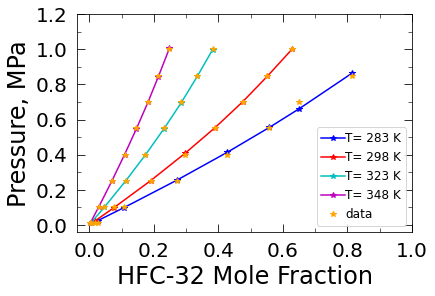

In [13]:
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

fig, ax = plt.subplots()

ax.plot(R32_x[0:7],P1[0:7],"b*-",label="T= 283 K")  
ax.plot(R32_x[7:15],P1[7:15],"r*-",label="T= 298 K") 
ax.plot(R32_x[15:23],P1[15:23],"c*-",label="T= 323 K") 
ax.plot(R32_x[23:31],P1[23:31],"m-*",label="T= 348 K")
ax.plot(data_full["x_R32"],data_full["pressure"]/1e6,"*",color='orange',label="data")  

# plt.title('Isotherm R32-[emim][TF2N]')
ax.set_ylabel('Pressure, MPa',fontsize=24)
ax.set_xlabel('HFC-32 Mole Fraction',fontsize=24)

ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9],minor=True)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1],minor=True)

ax.tick_params("both", direction="in", which="both", length=4, labelsize=20, pad=10)
ax.tick_params("both", which="major", length=8)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(fontsize=12, handletextpad=0.00, loc="lower right")#, bbox_to_anchor=(1, 0.5))
fig.savefig('R32-bmimpf6-quadTdep.pdf',bbox_inches='tight')
plt.show()

### Print Eigvals, Eigvectors

An identifiability analysis can be performed with these as well as a FIM because the covariance matrix is the inverse of the FIM. That means that if there are any eigvals > 0, their eigvecs indicate directions of un-identifiability.

In [14]:
eigvals, eigvecs = np.linalg.eig(cov)

In [15]:
eigvals

array([5.31619172e+01, 1.41481648e-01, 1.59832752e-02, 6.36129316e-05,
       1.00426521e-05, 5.85656694e-08])

In [16]:
eigvecs

array([[ 0.408039  ,  0.26442256,  0.63442689, -0.41902848,  0.4289742 ,
        -0.03851857],
       [ 0.01070922,  0.4070236 , -0.15877553, -0.52688748, -0.49268852,
         0.53726626],
       [-0.81652582,  0.01639564, -0.02748373, -0.41145225,  0.40177266,
        -0.03933444],
       [-0.0217119 , -0.74978134,  0.32014147, -0.07758675, -0.01496131,
         0.57325599],
       [ 0.40753361, -0.29173207, -0.66460559, -0.40730642,  0.37360607,
        -0.04035033],
       [ 0.01095581,  0.34185381, -0.1653673 ,  0.45342424,  0.52154823,
         0.61486869]])

In [17]:
np.savetxt('Data/EigenAnalysis/PR_vals_6parameter.csv',eigvals,delimiter=',')
np.savetxt('Data/EigenAnalysis/PR_vecs_6parameter.csv',eigvecs,delimiter=',')

Conclusion: Fully identifiable because all eigvals ~ 0

## AIC Value

See https://docs.google.com/document/d/1um0r2XK4ldjjy2colOqaZsEM3wIzGD6l_3B8gnpnI2I/edit# for equations

Other AIC - using SSR calculated in above parameter fitting

In [18]:
n=6

In [19]:
SSR_other = obj_value*1E-2

In [20]:
SSR_other

0.08191387573758713

In [21]:
sigma_sq_other = SSR_other/n
sigma_sq_other

0.013652312622931187

In [22]:
L_other = -n/2*np.log(2*np.pi) - n/2*np.log(sigma_sq_other) - 1/(2*sigma_sq_other)*SSR_other
L_other

4.367907847100715

In [23]:
AIC_other = 2*n - 2*L_other
AIC_other

3.2641843057985707

In [24]:
AIC_data = pd.DataFrame(data=[n,obj_value*1e-2,AIC_other])
AIC_data = AIC_data.T
AIC_data.columns = ['n','Objective, Pa^2','AIC']
AIC_data.to_csv('Data/AIC/PR_AIC_6parameter.csv')